# Cluster Analysis

## 1. Import Required Libraries

In [1]:
from pathlib import Path

import os 
os.environ["OMP_NUM_THREADS"] = "1" # This is done to set 
# OMP_NUM_THREADS to 1 for comparison of various k in 
# k-Means clustering.

import pandas as pd
import numpy as np
import seaborn as sns

from sklearn import preprocessing
from sklearn.metrics import pairwise
from sklearn.cluster import KMeans

from scipy.cluster.hierarchy import dendrogram, linkage, fcluster

from pandas.plotting import parallel_coordinates

%matplotlib inline
import matplotlib.pylab as plt

## 2. Load data on 22 public utilities and compute distance matrix.

In [9]:
# Create data frame for Utilities data set.
utilities_df = pd.read_csv('Utilities.csv')

# Set row names (index) to 'Company', which is utilities
# column name. 
utilities_df.set_index('Company', inplace=True)

# Display records of utilities_df data frame.
utilities_df

,Fixed_Charge,RoR,Cost,Load_Factor,Demand_Growth,Sales,Nuclear,Fuel_Cost
Company,,,,,,,,
Arizona,1.06,9.2,151,54.4,1.6,9077,0.0,0.628
Boston,0.89,10.3,202,57.9,2.2,5088,25.3,1.555
Central,1.43,15.4,113,53.0,3.4,9212,0.0,1.058
Commonwealth,1.02,11.2,168,56.0,0.3,6423,34.3,0.700
NY,1.49,8.8,192,51.2,1.0,3300,15.6,2.044
Florida,1.32,13.5,111,60.0,-2.2,11127,22.5,1.241
Hawaiian,1.22,12.2,175,67.6,2.2,7642,0.0,1.652
Idaho,1.10,9.2,245,57.0,3.3,13082,0.0,0.309
Kentucky,1.34,13.0,168,60.4,7.2,8406,0.0,0.862


In [11]:
# Normilize input variables and compute nomalized distance matrix. 


# There are two ways to normalize the input variables. 
# Scikit-learn uses the population standard deviation,
# wheres Pandas calculates by default the sample standard deviation. 
# The normalized data from the two methods will therefore differ slightly. 
# We will use the Pandas approach as more appropriate for cluster analysis.

# Scikit-learn uses population standard deviation, will not be used
# in this cluster analysis. 
utilities_df_norm = utilities_df.apply(preprocessing.scale, axis=0)

# Pandas uses sample standard deviation; will apply in cluster analysis. 
utilities_df_norm = (utilities_df - utilities_df.mean())/utilities_df.std()
utilities_df_norm_round = np.round((utilities_df - utilities_df.mean())/utilities_df.std(), 
                          decimals=2)

# Display records of utilities_df data frame.
print('Normalized Input Variables for Five Utilities')
utilities_df_norm_round.head()

Normalized Input Variables for Five Utilities


,Fixed_Charge,RoR,Cost,Load_Factor,Demand_Growth,Sales,Nuclear,Fuel_Cost
Company,,,,,,,,
Arizona,-0.29,-0.68,-0.42,-0.58,-0.53,0.05,-0.71,-0.85
Boston,-1.21,-0.19,0.82,0.21,-0.33,-1.08,0.79,0.81
Central,1.71,2.08,-1.34,-0.89,0.05,0.08,-0.71,-0.08
Commonwealth,-0.51,0.21,-0.00,-0.22,-0.94,-0.70,1.33,-0.72
NY,2.04,-0.86,0.58,-1.30,-0.72,-1.58,0.21,1.69


In [13]:
#Calculate Distance based on only two variables first


# Compute Euclidean distance matrix, metric='euclidean'.
# To compute other metrics, e.g., 'cityblock', 'cosine', 
# 'manhattan', etc., change the name of metric argument.
# d = pairwise.pairwise_distances(utilities_df, metric='euclidean')


d_norm_round = np.round(pairwise.pairwise_distances(utilities_df_norm[['Sales', 'Fuel_Cost']], 
                    metric='euclidean'), decimals=2)

# Display normalized distances based on 'Sales' and 'Fuel_Cost'
print('Normalized Distances for Five Utilities')
pd.DataFrame(d_norm_round, columns=utilities_df.index, index=utilities_df.index).head()

Normalized Distances for Five Utilities


Company,Arizona,Boston,Central,Commonwealth,NY,Florida,Hawaiian,Idaho,Kentucky,Madison,...,Northern,Oklahoma,Pacific,Puget,San Diego,Southern,Texas,Wisconsin,United,Virginia
Company,,,,,,,,,,,,,,,,,,,,,
Arizona,0.00,2.01,0.77,0.76,3.02,1.24,1.89,1.27,0.46,0.74,...,0.56,0.18,1.57,1.95,2.51,0.91,1.25,0.52,2.76,1.25
Boston,2.01,0.00,1.47,1.58,1.01,1.79,0.74,3.18,1.56,1.72,...,1.94,2.17,0.48,3.50,0.68,1.63,2.89,1.65,1.10,1.48
Central,0.77,1.47,0.00,1.02,2.43,0.63,1.16,1.73,0.42,1.10,...,1.11,0.86,0.99,2.07,1.84,0.28,1.43,0.84,2.03,0.51
Commonwealth,0.76,1.58,1.02,0.00,2.57,1.64,1.75,2.00,0.63,0.14,...,0.38,0.94,1.26,2.70,2.20,1.28,2.00,0.24,2.55,1.50
NY,3.02,1.01,2.43,2.57,0.00,2.64,1.41,4.16,2.57,2.71,...,2.94,3.17,1.46,4.40,0.72,2.56,3.83,2.66,0.95,2.33


## 3.  Develop and plot hierachical dendrograms for different measures of distance between clusters. 

- Note that above distandces was just an idea to see how distance are between two Cities.
- Linkage function measure distane and even form group of clusters for all variables by the provided linkage method.

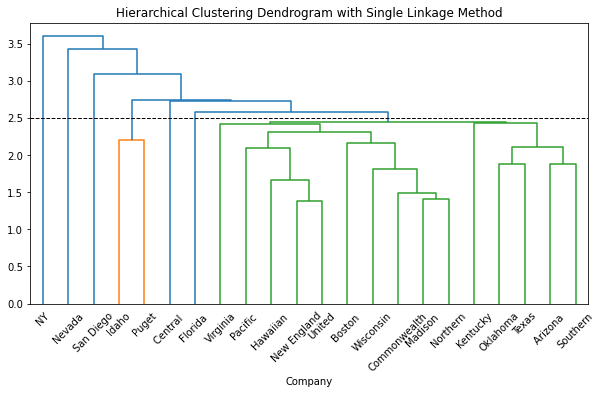

In [14]:
# Develop hierachical (agglomerative) clustering using single 
# linkage (minimal distance) for clustering. 
hi_single = linkage(utilities_df_norm, method='single')

# Plot hierachical clustering dendrogram with single linkage
# measure of distance between clusters. 

# Develop plot parameters, title and labels. 
fig = plt.figure(figsize=(10, 6))
fig.subplots_adjust(bottom=0.23)
plt.title('Hierarchical Clustering Dendrogram with Single Linkage Method')
plt.xlabel('Company')

# Use dendrogram() function to develop hierachical clustering deondrogram
# clusters with single linkage. 
# 'color_threshold = 2.5' represents the threthold of cluster development. 
# It is a normalized dinstance between clusters (2.5), at which the 
# agglomeration of records into clusters will stop. 
# The higher this value, the less clusters will be created. 
dendrogram(hi_single, labels=utilities_df_norm.index, color_threshold=2.5)

# Develop the horizontal line representing the cluister development
# threshold (2.5) and plot the dendrogram.
plt.axhline(y=2.5, color='black', linewidth=1.0, linestyle='dashed')
plt.show()

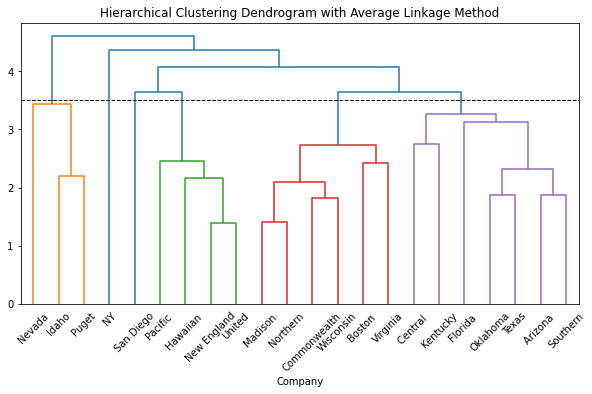

In [15]:
# Now lets make the linkage (group of clusters) based upon average linkage:

# Develop hierachical (agglomerative) clustering using average 
# linkage (average distance) for clustering. 
hi_average = linkage(utilities_df_norm, method='average')

# Develop plot parameters, title and labels.  
fig = plt.figure(figsize=(10, 6))
fig.subplots_adjust(bottom=0.23)
plt.title('Hierarchical Clustering Dendrogram with Average Linkage Method')
plt.xlabel('Company')

# Use dendrogram() function to develop hierachical clustering deondrogram
# clusters with average linkage (average distance). 
# 'color_threshold = 3.5' represents the threthold of cluster development. 
# It is a normalized dinstance between clusters (3.5), at which the 
# agglomeration of records into clusters will stop. 
# The higher this value, the less clusters will be created. 
dendrogram(hi_average, labels=utilities_df_norm.index, color_threshold=3.5)

# Develop the horizontal line representing the cluister development
# threshold (3.5) and plot the dendrogram.
plt.axhline(y=3.5, color='black', linewidth=1.0, linestyle='dashed')
plt.show()

## 4. Cluster membership,  cluster means, profile plots, and heatmap for clusters with average linkage. 

In [16]:
# Develop cluster membership for agglomerative clustering using average 
# linkage method. The number of clusters is assigned to be 6 as shown
# in the dendrogram with average linkage.  

#Fcluter helps us to find memebrs in a cluster
memb_ave = fcluster(hi_average, 6, criterion='maxclust')
memb_ave = pd.Series(memb_ave, index=utilities_df_norm.index)

# Display cluster memberships for 6 clusters.  
print('Cluster Membership for 6 Clusters Using Average Linkage Method')
for key, item in memb_ave.groupby(memb_ave):
    print(key, ' : ',' , '.join(item.index))

Cluster Membership for 6 Clusters Using Average Linkage Method
1  :  Idaho , Nevada , Puget
2  :  Hawaiian  , New England , Pacific  , United
3  :  San Diego
4  :  Boston  , Commonwealth , Madison  , Northern , Wisconsin , Virginia
5  :  Arizona  , Central  , Florida  , Kentucky , Oklahoma , Southern , Texas
6  :  NY


In [18]:
#We can even cheack the mean value for each variable in each of above 6 clusters.

# Identify  and display cluster original mean values 
# for each of 8 input variables (measurements).

# Create data frame with original cluster means for each 
# cluster and each input variable (measurement).
clust_mean = utilities_df.groupby(memb_ave).mean()

# Add cluster titles (Cluster 1, Cluster 2, ...) to cluster_mean
# data frame with means and precision of 3 decimals. 
clust_mean['Cluster'] = ['Cluster {}'.format(i) for i in clust_mean.index]
pd.set_option('precision', 3)

# Display the data frame with mean values and cluster titles.
print('Means of Input Variables for Clusters with Average Linkage Method')
clust_mean

Means of Input Variables for Clusters with Average Linkage Method


,Fixed_Charge,RoR,Cost,Load_Factor,Demand_Growth,Sales,Nuclear,Fuel_Cost,Cluster
1,1.003,8.867,223.333,54.833,6.333,15504.667,0.000,0.566,Cluster 1
2,1.087,9.825,180.250,63.200,2.325,6728.500,0.225,1.766,Cluster 2
3,0.760,6.400,136.000,61.900,9.000,5714.000,8.300,1.920,Cluster 3
4,1.075,11.283,181.333,55.800,3.500,7087.500,36.117,0.902,Cluster 4
5,1.207,12.486,127.571,55.471,1.714,10163.143,3.214,0.874,Cluster 5
6,1.490,8.800,192.000,51.200,1.000,3300.000,15.600,2.044,Cluster 6


In [21]:
# Identify  and display cluster original mean values 
# for each of 8 input variables (measurements).

# Create data frame with original cluster means for each 
# cluster and each input variable (measurement).
clust_mean = utilities_df.groupby(memb_ave).mean()

# Add cluster titles (Cluster 1, Cluster 2, ...) to cluster_mean
# data frame with means and precision of 3 decimals. 
clust_mean['Cluster'] = ['Cluster {}'.format(i) for i in clust_mean.index]
pd.set_option('precision', 3)

# Display the data frame with mean values and cluster titles.
print('Means of Input Variables for Clusters with Average Linkage Method')
clust_mean

Means of Input Variables for Clusters with Average Linkage Method


,Fixed_Charge,RoR,Cost,Load_Factor,Demand_Growth,Sales,Nuclear,Fuel_Cost,Cluster
1,1.003,8.867,223.333,54.833,6.333,15504.667,0.000,0.566,Cluster 1
2,1.087,9.825,180.250,63.200,2.325,6728.500,0.225,1.766,Cluster 2
3,0.760,6.400,136.000,61.900,9.000,5714.000,8.300,1.920,Cluster 3
4,1.075,11.283,181.333,55.800,3.500,7087.500,36.117,0.902,Cluster 4
5,1.207,12.486,127.571,55.471,1.714,10163.143,3.214,0.874,Cluster 5
6,1.490,8.800,192.000,51.200,1.000,3300.000,15.600,2.044,Cluster 6


In [20]:
# same can be oberved for the normalized dataset as well.

# Identify  and display cluster normalized mean values 
# for each of 8 input variables (measurements).

# Create data frame with normalized cluster means for each 
# cluster and each input variable (measurement). 
clust_mean_norm = utilities_df_norm.groupby(memb_ave).mean()

# Add cluster titles (Cluster 1, Cluster 2, ...) to the 
# cluster_mean_norm data frame with means and get precision 
# of 3 decimals.
clust_mean_norm['Cluster'] = ['Cluster {}'.format(i) for i in clust_mean_norm.index]
pd.set_option('precision', 3)

# Display the data frame with normalized mean values and cluster titles.
print('Normalized Means of Input Variables for Clusters with Average Linkage Method')
clust_mean_norm

Normalized Means of Input Variables for Clusters with Average Linkage Method


,Fixed_Charge,RoR,Cost,Load_Factor,Demand_Growth,Sales,Nuclear,Fuel_Cost,Cluster
1,-0.600,-0.833,1.339,-0.481,0.992,1.857,-0.715,-0.966,Cluster 1
2,-0.144,-0.406,0.293,1.395,-0.294,-0.616,-0.701,1.193,Cluster 2
3,-1.919,-1.932,-0.781,1.103,1.847,-0.901,-0.220,1.470,Cluster 3
4,-0.212,0.244,0.319,-0.264,0.083,-0.515,1.436,-0.361,Cluster 4
5,0.504,0.780,-0.986,-0.338,-0.490,0.352,-0.523,-0.411,Cluster 5
6,2.037,-0.863,0.578,-1.295,-0.719,-1.581,0.214,1.693,Cluster 6


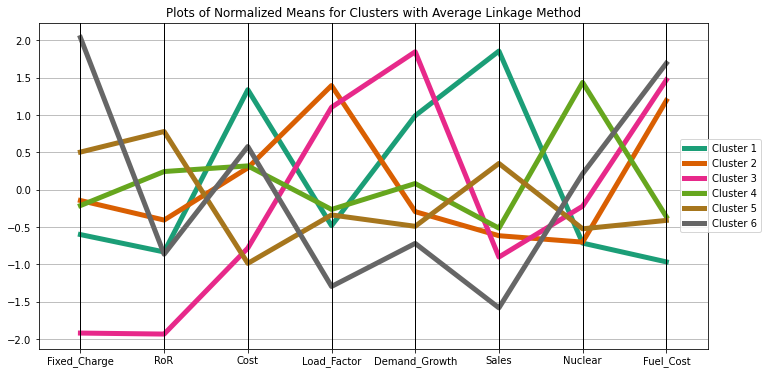

In [22]:
# Display profile plots for normalized means for each cluster and
# each input variable (measurement).
plt.figure(figsize=(12,6))
fig.subplots_adjust(right=3)
ax = parallel_coordinates(clust_mean_norm, class_column='Cluster', 
                          colormap='Dark2', linewidth=5)
plt.legend(loc='center left', bbox_to_anchor=(0.95, 0.5))
plt.xlim(-0.5,7.5)
plt.title('Plots of Normalized Means for Clusters with Average Linkage Method')
plt.show()


Heatmap for Utulities Hiarachical Clustering with Average Linkage Method


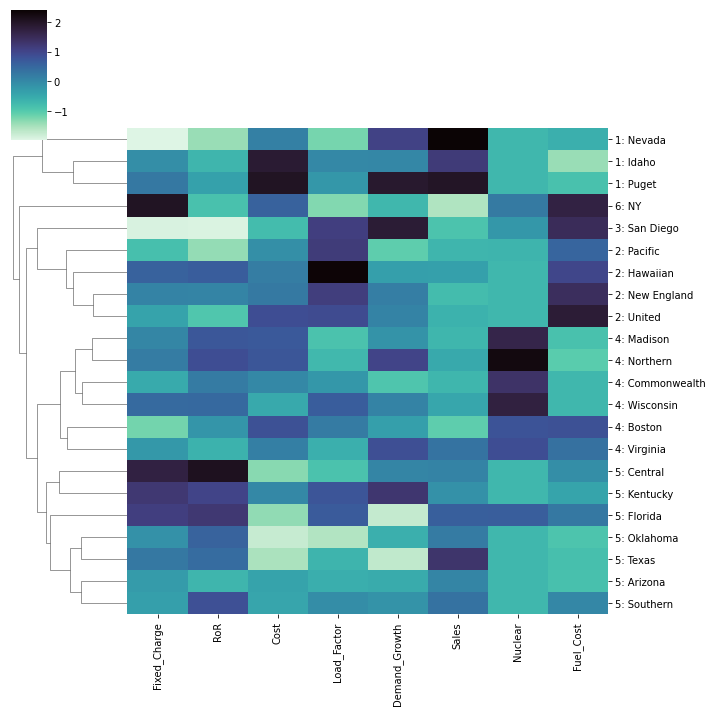

In [23]:
# Create and display heatmap for Utulities hiarachical clustering 
# with average linkage method. 
utilities_df_norm.index = ['{}: {}'.format(cluster, state) for cluster, 
                           state in zip(memb_ave, utilities_df_norm.index)]
sns.clustermap(utilities_df_norm, method='average', col_cluster=False,  
                          cmap="mako_r")
print('Heatmap for Utulities Hiarachical Clustering with Average Linkage Method')
plt.show()